In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [37]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = cifar10.load_data()
train_images = (train_images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1,1]
train_images = train_images.reshape(-1, 32, 32, 3)  # CIFAR-10 images are (32, 32, 3)

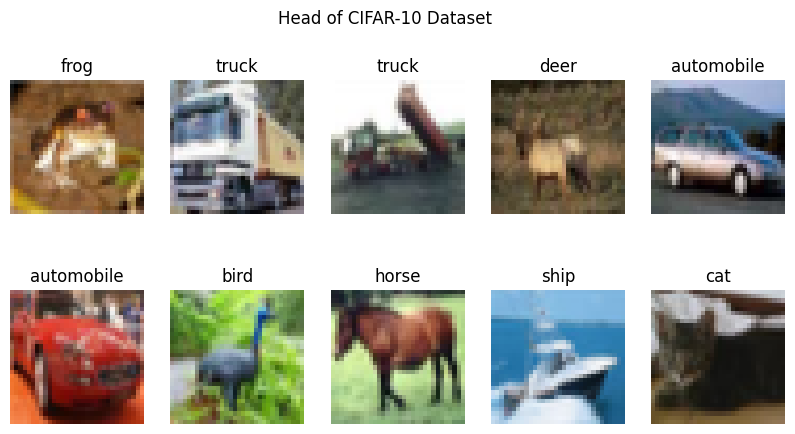

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_images, train_labels), (_, _) = cifar10.load_data()

# CIFAR-10 Class Names
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

# Display the first few images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])  # Use class_names to label images
    plt.axis("off")

plt.suptitle("Head of CIFAR-10 Dataset")
plt.show()


In [39]:
BUFFER_SIZE = 20000
BATCH_SIZE = 16
EPOCHS = 50
NOISE_DIM = 100

In [40]:
# Create batches of training data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [41]:
# Function to create the Generator
def build_generator():
    model = Sequential([
        Dense(8 * 8 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((8, 8, 256)),
        
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [42]:
# Discriminator now weaker (to balance training)
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 3)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        
        Flatten(),
        Dense(1, activation='sigmoid')  # ✅ Sigmoid ensures probability output
    ])
    return model

discriminator = build_discriminator()
print("Discriminator Model Defined")


Discriminator Model Defined


In [43]:

# Create Generator and Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Define Loss Function and Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)


In [44]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_16 (Ba  (None, 16384)             65536     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 16, 16, 128)       524288    
 DTranspose)                                                     
                                                                 
 batch_normalization_17 (Ba  (None, 16, 16, 128)      

In [45]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)            

In [46]:
# Function to compute the loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [47]:
# Define Training Step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [48]:
import matplotlib.pyplot as plt

def generate_and_save_images(epoch):
    noise = tf.random.normal([16, NOISE_DIM])
    generated_images = generator(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        img = (generated_images[i] + 1) / 2  # Normalize from [-1,1] to [0,1]
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle(f"Generated Images at Epoch {epoch}")
    
    plt.show()  #Ensures the image is displayed in Jupyter Notebook

    # Also save the images for reference
    plt.savefig(f"generated_images_epoch_{epoch}.png")


In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

print("Training Started...")

for epoch in range(EPOCHS):
    start_time = time.time()

    for image_batch in train_dataset:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                        cross_entropy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    end_time = time.time()
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f} - Time Taken: {end_time - start_time:.2f} sec")

    # Ensure images are displayed after every epoch
    generate_and_save_images(epoch + 1)

# Save Models After Training
generator.save("cifar10_generator_1.h5")
discriminator.save("cifar10_discriminator_1.h5")
print("Training Complete and Models Saved!")


Training Started...


In [42]:
# Plot the loss curves at the end
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), gen_losses, label="Generator Loss", marker='o')
plt.plot(range(1, EPOCHS + 1), disc_losses, label="Discriminator Loss", marker='x')
plt.title("Generator and Discriminator Loss Over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Function to compute FID score
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(32, 32, 3))
    
    real_images = preprocess_input((real_images + 1) * 127.5)  # Rescale back to [0,255]
    generated_images = preprocess_input((generated_images + 1) * 127.5)
    
    real_features = model.predict(real_images)
    generated_features = model.predict(generated_images)
    
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
    
    fid_score = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))
    return fid_score


In [ ]:
# Generate images for FID Calculation
num_images = 1000
real_images = train_images[:num_images]
noise = tf.random.normal([num_images, NOISE_DIM])
generated_images = generator(noise, training=False)

# Compute FID Score
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")